# 1. Technical Setup

## Importing Packages

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
%matplotlib inline

from datetime import datetime
import functools
import gc
import pkg_resources
import types
from IPython.display import display, Markdown

# stats packages
import scipy.stats as stats
from scipy.stats import pointbiserialr
from scipy.stats import chi2_contingency
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from sklearn import metrics
from sklearn import preprocessing

## Setting up package management

In [ ]:
#package management
def get_imports():
    """ Get a list of packages and versions for README.md

        INPUTS:
        -----------
            None

        OUTPUTS:
        -----------
            list of tuples with package names and tuples
    """
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package,
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

imports = list(set(get_imports()))

# Get the versions of the root package
# by cross-checking the names of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

## Setting up themes

In [ ]:
#defining theme
plt.style.use('dark_background')
plt.rcParams['axes.grid'] = False
plt.rcParams['axes.facecolor'] = '#121212'
plt.rcParams['axes.labelcolor'] = '#F2F2F2'
plt.rcParams['xtick.color'] = '#F2F2F2'
plt.rcParams['ytick.color'] = '#F2F2F2'

---

# 2. Data Understanding

## About the data

Link to dataset: https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis

Variables Description:

- **ID**: A unique identifier for each customer. This feature may not contribute to a predictive model.

- **Year_Birth**: The birth year of customers, which can be converted to 'Age'.

- **Education** and **Marital_Status**: Categorical features that may require one-hot encoding.

- **Income**: A continuous feature indicating customer's income, with some missing values that need to be filled.

- **Kidhome** and **Teenhome**: Integer variables indicating the number of children in the household.

- **Dt_Customer**: The joining date of customers, which may need to be converted to 'tenure' or similar measure.

- **Recency**: Indicates how recently a customer made a purchase. Further context is needed for proper interpretation.

- **MntX** and **NumXPurchases**: Represent the amount spent on different categories of products and the number of purchases made through different channels, respectively.

- **AcceptedCmpX**: Binary features indicating whether the customer accepted offers in different campaigns.

- **Complain**: A binary feature indicating if the customer made a complaint recently.

- **Z_CostContact** and **Z_Revenue**: Features with no variance, hence can be removed.

- **Response**: The binary target variable indicating whether a customer accepted the latest offer.

## Data Collection

In [ ]:
df_raw = pd.read_csv('marketing_campaign.csv', sep='\t')
print(df_raw.shape)

(2240, 29)


## Data Overview

In [ ]:
df_raw.head(5)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [ ]:
def printmd(string):
    display(Markdown(string))

def get_dataframe_summary(df, cat_list, dummy_list):
    """ Autogenerate a dataframe summary in addition to the dataframe-describe() function

        INPUTS:
        ----------
            df -  (pandas dataframe) which should be described in an overview
            cat_list - (list) of all categorical input features
            dummy_list - (list) of all dummy input features

        OUTPUTS:
        ----------
            No return
            print statements
            text_for_readme.txt - an auto generated text document with df dataframe summary for the README

    """

    number_nan = df.isnull().sum()
    printmd('### DataFrame Overview')
    printmd('- Dataset with {} observations and {} columns'.format(df.shape[0], df.shape[1]))

    text_for_readme = '## DataFrame Overview\n'
    text_for_readme += 'Dataset with {} observations and {} columns\n\n'.format(df.shape[0], df.shape[1])

    print('___________________________________')
    printmd('- **Numerical** columns:')

    text_for_readme += '- **Numerical** columns:\n\n'
    text_for_readme += '\t| column_name | type | min | max | number NaN | number unique | sample unique |\n\t| :-------------  | :-------------  | :-------------  | :-------------  | :-------------  | :-------------  |\n'
    row_num = []
    count_int = 0
    count_float = 0
    for col in df.columns.tolist():
        if (df[col].dtypes == 'float64' or df[col].dtypes == 'int64') and col not in cat_list and col not in dummy_list:
            row_num.append([col, df[col].dtypes, df[col].min(), df[col].max(), number_nan[col], df[col].nunique(), df[col].unique()[:5]])
            text_for_readme +=('\t| ' + str(col) + ' | ' + str(df[col].dtypes) + ' | ' + str(df[col].min()) + ' | ' + str(df[col].max()) + ' | '+ str(number_nan[col]) + ' | ' + str(df[col].nunique()) + ' | ' + str(df[col].unique()[:5]) + ' |\n')
            if df[col].dtypes == 'int64':
                count_int += 1
            if df[col].dtypes == 'float64':
                count_float += 1
    df_num = pd.DataFrame(row_num,columns=['column_name', 'type', 'min', 'max', 'number NaN', 'number unique', 'sample unique'])
    text_for_readme +='\n\n'
    display(df_num)

    print('___________________________________')
    printmd('- **Categorical** columns:')

    text_for_readme += '- **Categorical** columns:\n\n'
    text_for_readme += '\t| column_name | type | min | max | number NaN | number unique | sample unique |\n\t| :-------------  | :-------------  | :-------------  | :-------------  | :-------------  | :-------------  |\n'
    row_cat = []
    count_object = 0
    for col in df.columns.tolist():
        if df[col].dtypes == 'object' or col in cat_list:
            try:
                row_cat.append([col, df[col].dtypes, df[col].min(), df[col].max(), number_nan[col], df[col].nunique(), df[col].unique()[:5]])
                text_for_readme +=('\t| ' + str(col) + ' | ' + str(df[col].dtypes) + ' | ' + str(df[col].min()) + ' | ' + str(df[col].max()) + ' | '+ str(number_nan[col]) + ' | ' + str(df[col].nunique()) + ' | ' + str(df[col].unique()[:5]) + ' |\n')
            except:
                row_cat.append([col, df[col].dtypes, 'NaN', 'NaN', number_nan[col], df[col].nunique(), df[col].unique()[:5]])
                text_for_readme +=('\t| ' + str(col) + ' | ' + str(df[col].dtypes) + ' | '+ 'NaN' + ' | '+ 'NaN' + ' | '+ str(number_nan[col]) + ' | ' + str(df[col].nunique()) + ' | ' + str(df[col].unique()[:5]) + ' |\n')
            count_object += 1
    df_cat = pd.DataFrame(row_cat,columns=['column_name', 'type', 'min', 'max', 'number NaN', 'number unique', 'sample unique'])
    text_for_readme +='\n\n'
    display(df_cat)

    print('___________________________________')
    printmd('- **Dummy** columns:')

    text_for_readme += '- **Dummy** columns:\n\n'
    text_for_readme += '\t| column_name | type | min | max | number NaN | number unique | sample unique |\n\t| :-------------  | :-------------  | :-------------  | :-------------  | :-------------  | :-------------  |\n'
    row_dummy = []
    for col in dummy_list:
        if (df[col].dtypes == 'float64' or df[col].dtypes == 'int64'):
            row_dummy.append([col, df[col].dtypes, df[col].min(), df[col].max(), number_nan[col], df[col].nunique(), df[col].unique()[:5]])
            text_for_readme +=('\t| ' + str(col) + ' | ' + str(df[col].dtypes) + ' | ' + str(df[col].min()) + ' | ' + str(df[col].max()) + ' | '+ str(number_nan[col]) + ' | ' + str(df[col].nunique()) + ' | ' + str(df[col].unique()[:5]) + ' |\n')
    df_dummy = pd.DataFrame(row_dummy,columns=['column_name', 'type', 'min', 'max', 'number NaN', 'number unique', 'sample unique'])
    text_for_readme +='\n\n'
    display(df_dummy)

    print('___________________________________')
    printmd('- There are ***{} numerical*** ({}x int and {}x float) columns'.format(count_int + count_float, count_int, count_float))
    printmd('- There are ***{} categorical*** columns'.format(count_object))
    printmd('- There are ***{} dummy*** columns'.format(len(dummy_list)))

    print('___________________________________')
    printmd('- There are ***{} numerical*** ({}x int and {}x float) columns\n'.format(count_int + count_float, count_int, count_float))
    printmd('- There are ***{} categorical*** columns\n'.format(count_object))
    printmd('- There are ***{} dummy*** columns\n'.format(len(dummy_list)))
    printmd('- There are ***{} missing values*** in total in the dataset\n'.format(df.isnull().values.sum()))

    with open('text_for_readme.txt', 'w') as f:
        f.write(text_for_readme)

In [ ]:
cat_cols = df_raw.select_dtypes(include=['object']).columns.tolist()
binary_cols = [col for col in df_raw.columns if df_raw[col].nunique() == 2]
num_cols = [col for col in df_raw.columns if col not in cat_cols and col not in binary_cols]

get_dataframe_summary(df_raw, cat_list=cat_cols,dummy_list=binary_cols)

### DataFrame Overview

- Dataset with 2240 observations and 29 columns

___________________________________


- **Numerical** columns:

,column_name,type,min,max,number NaN,number unique,sample unique
0,ID,int64,0.0,11191.0,0,2240,"[5524, 2174, 4141, 6182, 5324]"
1,Year_Birth,int64,1893.0,1996.0,0,59,"[1957, 1954, 1965, 1984, 1981]"
2,Income,float64,1730.0,666666.0,24,1974,"[58138.0, 46344.0, 71613.0, 26646.0, 58293.0]"
3,Kidhome,int64,0.0,2.0,0,3,"[0, 1, 2]"
4,Teenhome,int64,0.0,2.0,0,3,"[0, 1, 2]"
5,Recency,int64,0.0,99.0,0,100,"[58, 38, 26, 94, 16]"
6,MntWines,int64,0.0,1493.0,0,776,"[635, 11, 426, 173, 520]"
7,MntFruits,int64,0.0,199.0,0,158,"[88, 1, 49, 4, 43]"
8,MntMeatProducts,int64,0.0,1725.0,0,558,"[546, 6, 127, 20, 118]"
9,MntFishProducts,int64,0.0,259.0,0,182,"[172, 2, 111, 10, 46]"


___________________________________


- **Categorical** columns:

,column_name,type,min,max,number NaN,number unique,sample unique
0,Education,object,2n Cycle,PhD,0,5,"[Graduation, PhD, Master, Basic, 2n Cycle]"
1,Marital_Status,object,Absurd,YOLO,0,8,"[Single, Together, Married, Divorced, Widow]"
2,Dt_Customer,object,01-01-2013,31-12-2013,0,663,"[04-09-2012, 08-03-2014, 21-08-2013, 10-02-201..."


___________________________________


- **Dummy** columns:

,column_name,type,min,max,number NaN,number unique,sample unique
0,AcceptedCmp3,int64,0,1,0,2,"[0, 1]"
1,AcceptedCmp4,int64,0,1,0,2,"[0, 1]"
2,AcceptedCmp5,int64,0,1,0,2,"[0, 1]"
3,AcceptedCmp1,int64,0,1,0,2,"[0, 1]"
4,AcceptedCmp2,int64,0,1,0,2,"[0, 1]"
5,Complain,int64,0,1,0,2,"[0, 1]"
6,Response,int64,0,1,0,2,"[1, 0]"


___________________________________


- There are ***19 numerical*** (18x int and 1x float) columns

- There are ***3 categorical*** columns

- There are ***7 dummy*** columns

___________________________________


- There are ***19 numerical*** (18x int and 1x float) columns


- There are ***3 categorical*** columns


- There are ***7 dummy*** columns


- There are ***24 missing values*** in total in the dataset


## Quality Checks

some common criteria for defining invalid values include:


* Values that are not numeric
* Values that are blank or empty
* Values that are repeated
* Values that are inconsistent with other values in the data set





In [ ]:
import pandas as pd
import numpy as np
from scipy import stats

def deep_data_quality_check_numerical(data, cols):
    """
    This function performs deep data quality checks for numerical data.

    Parameters:
    data (pd.DataFrame): The dataset to be checked.
    cols (list): The list of columns to be checked.

    Returns:
    A dictionary containing the results of the data quality checks.
    """

    # Initialize the dictionary to store the results
    results = {}

    for col in cols:
        # Check for missing values
        missing_values = data[col].isnull().sum()

        # Check for duplicate rows
        duplicate_rows = len(data) - len(data.drop_duplicates())

        # Check for outliers using the IQR method
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        outlier_index = data[(data[col] < (Q1 - 1.5 * IQR)) | (data[col] > (Q3 + 1.5 * IQR))].dropna(axis=0, how='all').index
        outliers_iqr = len(outlier_index)

        # Check for outliers using the Z-score method
        z_score = abs(stats.zscore(data[col]))
        outlier_index_z = data[col][z_score > 3].dropna(axis=0, how='all').index
        outliers_zscore = len(outlier_index_z)

        # Check for zero variance
        zero_variance = data[col].var() == 0

        # Check for high correlation
        corr_matrix = data.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
        high_correlation = [column for column in upper.columns if any(upper[column] > 0.5)]
        high_correlation = len(high_correlation)

        # Create a dictionary of the results for this column
        results[col] = {
            'missing_values': missing_values,
            'duplicate_rows': duplicate_rows,
            'outliers_iqr': outliers_iqr,
            'outliers_zscore': outliers_zscore,
            'zero_variance': zero_variance,
            'high_correlation': high_correlation
        }

    return results


In [ ]:
num_cols = [col for col in df_raw.columns if col not in cat_cols and col not in binary_cols]
results = deep_data_quality_check_numerical(df_raw, num_cols)

In [ ]:
pd.DataFrame(results).T

,missing_values,duplicate_rows,outliers_iqr,outliers_zscore,zero_variance,high_correlation
ID,0,0,0,0,False,8
Year_Birth,0,0,3,3,False,8
Income,24,0,8,0,False,8
Kidhome,0,0,0,0,False,8
Teenhome,0,0,0,0,False,8
Recency,0,0,0,0,False,8
MntWines,0,0,35,16,False,8
MntFruits,0,0,227,64,False,8
MntMeatProducts,0,0,175,37,False,8
MntFishProducts,0,0,223,58,False,8


Summary:

1. **missing_values**: Most columns have no missing values (0), except for the "Income" column, which has 24 missing values.

2. **duplicate_rows**: There are no duplicate rows in the dataset for any of the columns (all values are 0).

3. **outliers_iqr**: Several columns have outliers detected using the IQR (Interquartile Range) method. The "MntFruits," "MntMeatProducts," "MntFishProducts," "MntSweetProducts," and "MntGoldProds" columns have a relatively high number of outliers.

4. **outliers_zscore**: Outliers are also detected using the Z-score method. The columns "MntFruits," "MntMeatProducts," "MntFishProducts," "MntSweetProducts," and "MntGoldProds" have a significant number of outliers.

5. **zero_variance**:  The last two columns, "Z_CostContact" and "Z_Revenue," exhibit zero variance, as indicated by the "True" values

6. **high_correlation**: Most columns have a high correlation with other columns (value is 8), except for the "Z_CostContact" and "Z_Revenue" columns, which are labeled as "True." These two columns might not have enough variability to compute correlations effectively.

Based on these findings, steps to improve the data quality would include addressing the missing values in the "Income" column, investigating and possibly addressing outliers in columns with a high number of outliers, and considering the relevance of the "Z_CostContact" and "Z_Revenue" columns due to their low variability and correlation with other columns.

---

# Data Exploration

In [ ]:
#Initial Data Cleaning and Preprocessing
df = df_raw.copy(deep=True)

# 2. Missing Values Handling
df['Income'] = df['Income'].fillna(df['Income'].median())

# 3. New Features Derivation
# Calculate Age from Year_Birth
current_year = datetime.now().year
df['Age'] = current_year - df['Year_Birth']
df = df.drop('Year_Birth', axis=1)

# Calculate Customer_Tenure
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
last_recorded_date = df['Dt_Customer'].max()
df['Customer_Tenure'] = (last_recorded_date - df['Dt_Customer']).dt.days
df['Month_Joined'] = df['Dt_Customer'].dt.month

# Create Living_With feature based on Kidhome and Teenhome
conditions = [
    (df['Kidhome'] == 1) & (df['Teenhome'] == 0),
    (df['Kidhome'] == 0) & (df['Teenhome'] == 1),
    (df['Kidhome'] == 1) & (df['Teenhome'] == 1),
]

choices = ['With_Kids', 'With_Teens', 'With_Kids_and_Teens']
df['Living_With'] = np.select(conditions, choices, default='Alone')

# Create Is_Parent feature
df['Is_Parent'] = (df['Kidhome'] + df['Teenhome']).apply(lambda x: 1 if x > 0 else 0)

# Create Family_Size feature
df['Family_Size'] = np.where(
    df['Marital_Status'].isin(['Married', 'Together']),
    df['Kidhome'] + df['Teenhome'] + 1,
    df['Kidhome'] + df['Teenhome']
)

# Define generations
conditions = [
    (df['Age'] >= 76) & (df['Age'] <= 93),
    (df['Age'] >= 57) & (df['Age'] <= 75),
    (df['Age'] >= 41) & (df['Age'] <= 56),
    (df['Age'] >= 25) & (df['Age'] <= 40),
    (df['Age'] >= 9) & (df['Age'] <= 24),
    (df['Age'] >= 0) & (df['Age'] <= 11),
]

choices = ['Silent_Generation', 'Baby_Boomers', 'Generation_X', 'Millennials', 'Generation_Z', 'Generation_Alpha']
df['Generation'] = np.select(conditions, choices, default='Unknown')

# Create Total_Accepted_Campaigns feature
df['Total_Accepted_Campaigns'] = df[['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Response']].sum(axis=1)
df['AcceptedAnyCmp'] = df[['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Response']].any(axis=1).astype(int)
df['Engagement_Rate'] = (df['Total_Accepted_Campaigns'] / 6) * 100


# Derive RFM features
def rfm_segments(df):
    # Champions
    if df['Recency_Score'] >= 4 and df['Frequency_Score'] >= 4 and df['Monetary_Score'] >= 4:
        return 'Champions'
    # New
    elif df['Recency_Score'] >= 4 and df['Frequency_Score'] <= 2:
        return 'New'
    # Promising
    elif df['Recency_Score'] >= 3 and df['Frequency_Score'] <= 2:
        return 'Promising'
    # At Risk
    elif df['Recency_Score'] <= 2 and df['Frequency_Score'] >= 3 and df['Monetary_Score'] >= 3:
        return 'At Risk'
    # Can’t Lose Them
    elif df['Recency_Score'] <= 2 and df['Frequency_Score'] >= 4 and df['Monetary_Score'] >= 4:
        return 'Can’t Lose Them'
    # Lost
    else:
        return 'Lost'

df['Recency'] = (last_recorded_date - df['Dt_Customer']).dt.days
df['Total_Purchases'] = df['NumDealsPurchases'] + df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases']
df['Total_Spending'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']
df['Spend_per_Purchase'] = np.where(df['Total_Spending'] == 0, np.nan, df['Total_Spending'] / df['Total_Purchases'])

df['Recency_Score'] = pd.qcut(df['Recency'].rank(method='first'), 5, labels=[5,4,3,2,1]).astype(int)
df['Frequency_Score'] = pd.qcut(df['Total_Purchases'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
df['Monetary_Score'] = pd.qcut(df['Total_Spending'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
df['Avg_RFM'] = (df['Recency_Score'] + df['Frequency_Score'] + df['Monetary_Score'])/3


df = df.drop(['ID', 'Z_CostContact', 'Z_Revenue', 'Dt_Customer'], axis=1)


In [ ]:
plt.style.use('default')

In [ ]:
df

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Total_Accepted_Campaigns,AcceptedAnyCmp,Engagement_Rate,Total_Purchases,Total_Spending,Spend_per_Purchase,Recency_Score,Frequency_Score,Monetary_Score,Avg_RFM
0,Graduation,Single,58138.0,0,0,663,635,88,546,172,...,1,1,16.666667,25,1617,64.680000,1,5,5,3.666667
1,Graduation,Single,46344.0,1,1,113,11,1,6,2,...,0,0,0.000000,6,27,4.500000,5,1,1,2.333333
2,Graduation,Together,71613.0,0,0,312,426,49,127,111,...,0,0,0.000000,21,776,36.952381,3,4,4,3.666667
3,Graduation,Together,26646.0,1,0,139,11,4,20,10,...,0,0,0.000000,8,53,6.625000,5,2,1,2.666667
4,PhD,Married,58293.0,1,0,161,173,43,118,46,...,0,0,0.000000,19,422,22.210526,4,4,3,3.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,Graduation,Married,61223.0,0,1,381,709,43,182,42,...,0,0,0.000000,18,1341,74.500000,3,4,5,4.000000
2236,PhD,Together,64014.0,2,1,19,406,0,30,0,...,1,1,16.666667,22,444,20.181818,5,5,3,4.333333
2237,Graduation,Divorced,56981.0,0,0,155,908,48,217,32,...,1,1,16.666667,19,1241,65.315789,4,4,5,4.333333
2238,Master,Together,69245.0,0,1,156,428,30,214,80,...,0,0,0.000000,23,843,36.652174,4,5,4,4.333333


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_0, *['Income'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_1, *['Kidhome'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_2, *['Teenhome'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_3, *['Recency'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_4, *['Income'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_5, *['Kidhome'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_6, *['Teenhome'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_7, *['Recency'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(_df_8, *['Education'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(_df_9, *['Marital_Status'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(_df_10, *['Living_With'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(_df_11, *['Generation'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(_df_12, *[[['Income', 'Kidhome'], ['Kidhome', 'Teenhome'], ['Teenhome', 'Recency'], ['Recency', 'MntWines']]], **{})
chart

import numpy as np
from google.colab import autoviz

def heatmap(df, x_colname, y_colname, figscale=1, mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=(8 * figscale, 8 * figscale))
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(_df_13, *['Education', 'Marital_Status'], **{})
chart

import numpy as np
from google.colab import autoviz

def heatmap(df, x_colname, y_colname, figscale=1, mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=(8 * figscale, 8 * figscale))
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(_df_14, *['Marital_Status', 'Living_With'], **{})
chart

import numpy as np
from google.colab import autoviz

def heatmap(df, x_colname, y_colname, figscale=1, mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=(8 * figscale, 8 * figscale))
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(_df_15, *['Living_With', 'Generation'], **{})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(_df_16, *['Income', 'Education'], **{'inner': 'box'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(_df_17, *['Income', 'Marital_Status'], **{'inner': 'box'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(_df_18, *['Income', 'Living_With'], **{'inner': 'box'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(_df_19, *['Income', 'Generation'], **{'inner': 'box'})
chart

## Outliers

In [ ]:
num_df = df.select_dtypes(include=np.number)
nunique_df = pd.DataFrame(data=num_df.apply(pd.Series.nunique), columns=['nunique']).rename_axis('variables')
selection = nunique_df[nunique_df['nunique'] > 5].index

#plotly frame setup
to_plot = num_df[selection]

# number of variables to plot
num_vars = len(to_plot.columns)

# calculate number of rows and columns for the subplot grid
plot_nrows = int(np.ceil(num_vars / 4))

# create subplot titles
subplot_titles = list(to_plot.columns) + [''] * (plot_nrows * 4 - num_vars)

# create subplots
fig = make_subplots(rows=plot_nrows, cols=4, subplot_titles=tuple(subplot_titles))

# add traces
for i, col_name in enumerate(to_plot.columns):
    row = i // 4 + 1
    col = i % 4 + 1
    fig.add_trace(go.Box(y=to_plot[col_name], name=col_name), row=row, col=col)

fig.update_layout(height=1400, width=1200, showlegend=False, template='plotly_dark', title='Boxplot of Numerical Features')
fig.update_xaxes(visible=False, showticklabels=False)

fig.show()

In [ ]:
#Outliers Treatment
#filter multiple conditions
def conjunction(*conditions):
  return functools.reduce(np.logical_and, conditions)

cond1 = df.Age < 90
cond2 = df.Income < 150000
cond3 = df.NumCatalogPurchases < 11
cond4 = df.NumWebVisitsMonth < 13
cond5 = df.NumWebPurchases < 20
cond6 = df.MntSweetProducts < 200
cond7 = df.MntMeatProducts < 1500
cond8 = df.MntGoldProds < 290

df = df[conjunction(cond1, cond2, cond3, cond4, cond5, cond6, cond7, cond8)]
print("Number of data points before outlier removal:", len(df_raw))
print("Number of data points after outlier removal:", len(df))
print("Percentage of data points removed: {:.2f}%".format((len(df_raw) - len(df)) / len(df_raw) * 100))

Number of data points before outlier removal: 2240
Number of data points after outlier removal: 2195
Percentage of data points removed: 2.01%


## Exploring Marital_Status

In [ ]:
def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(df, *['Education'], **{})
chart

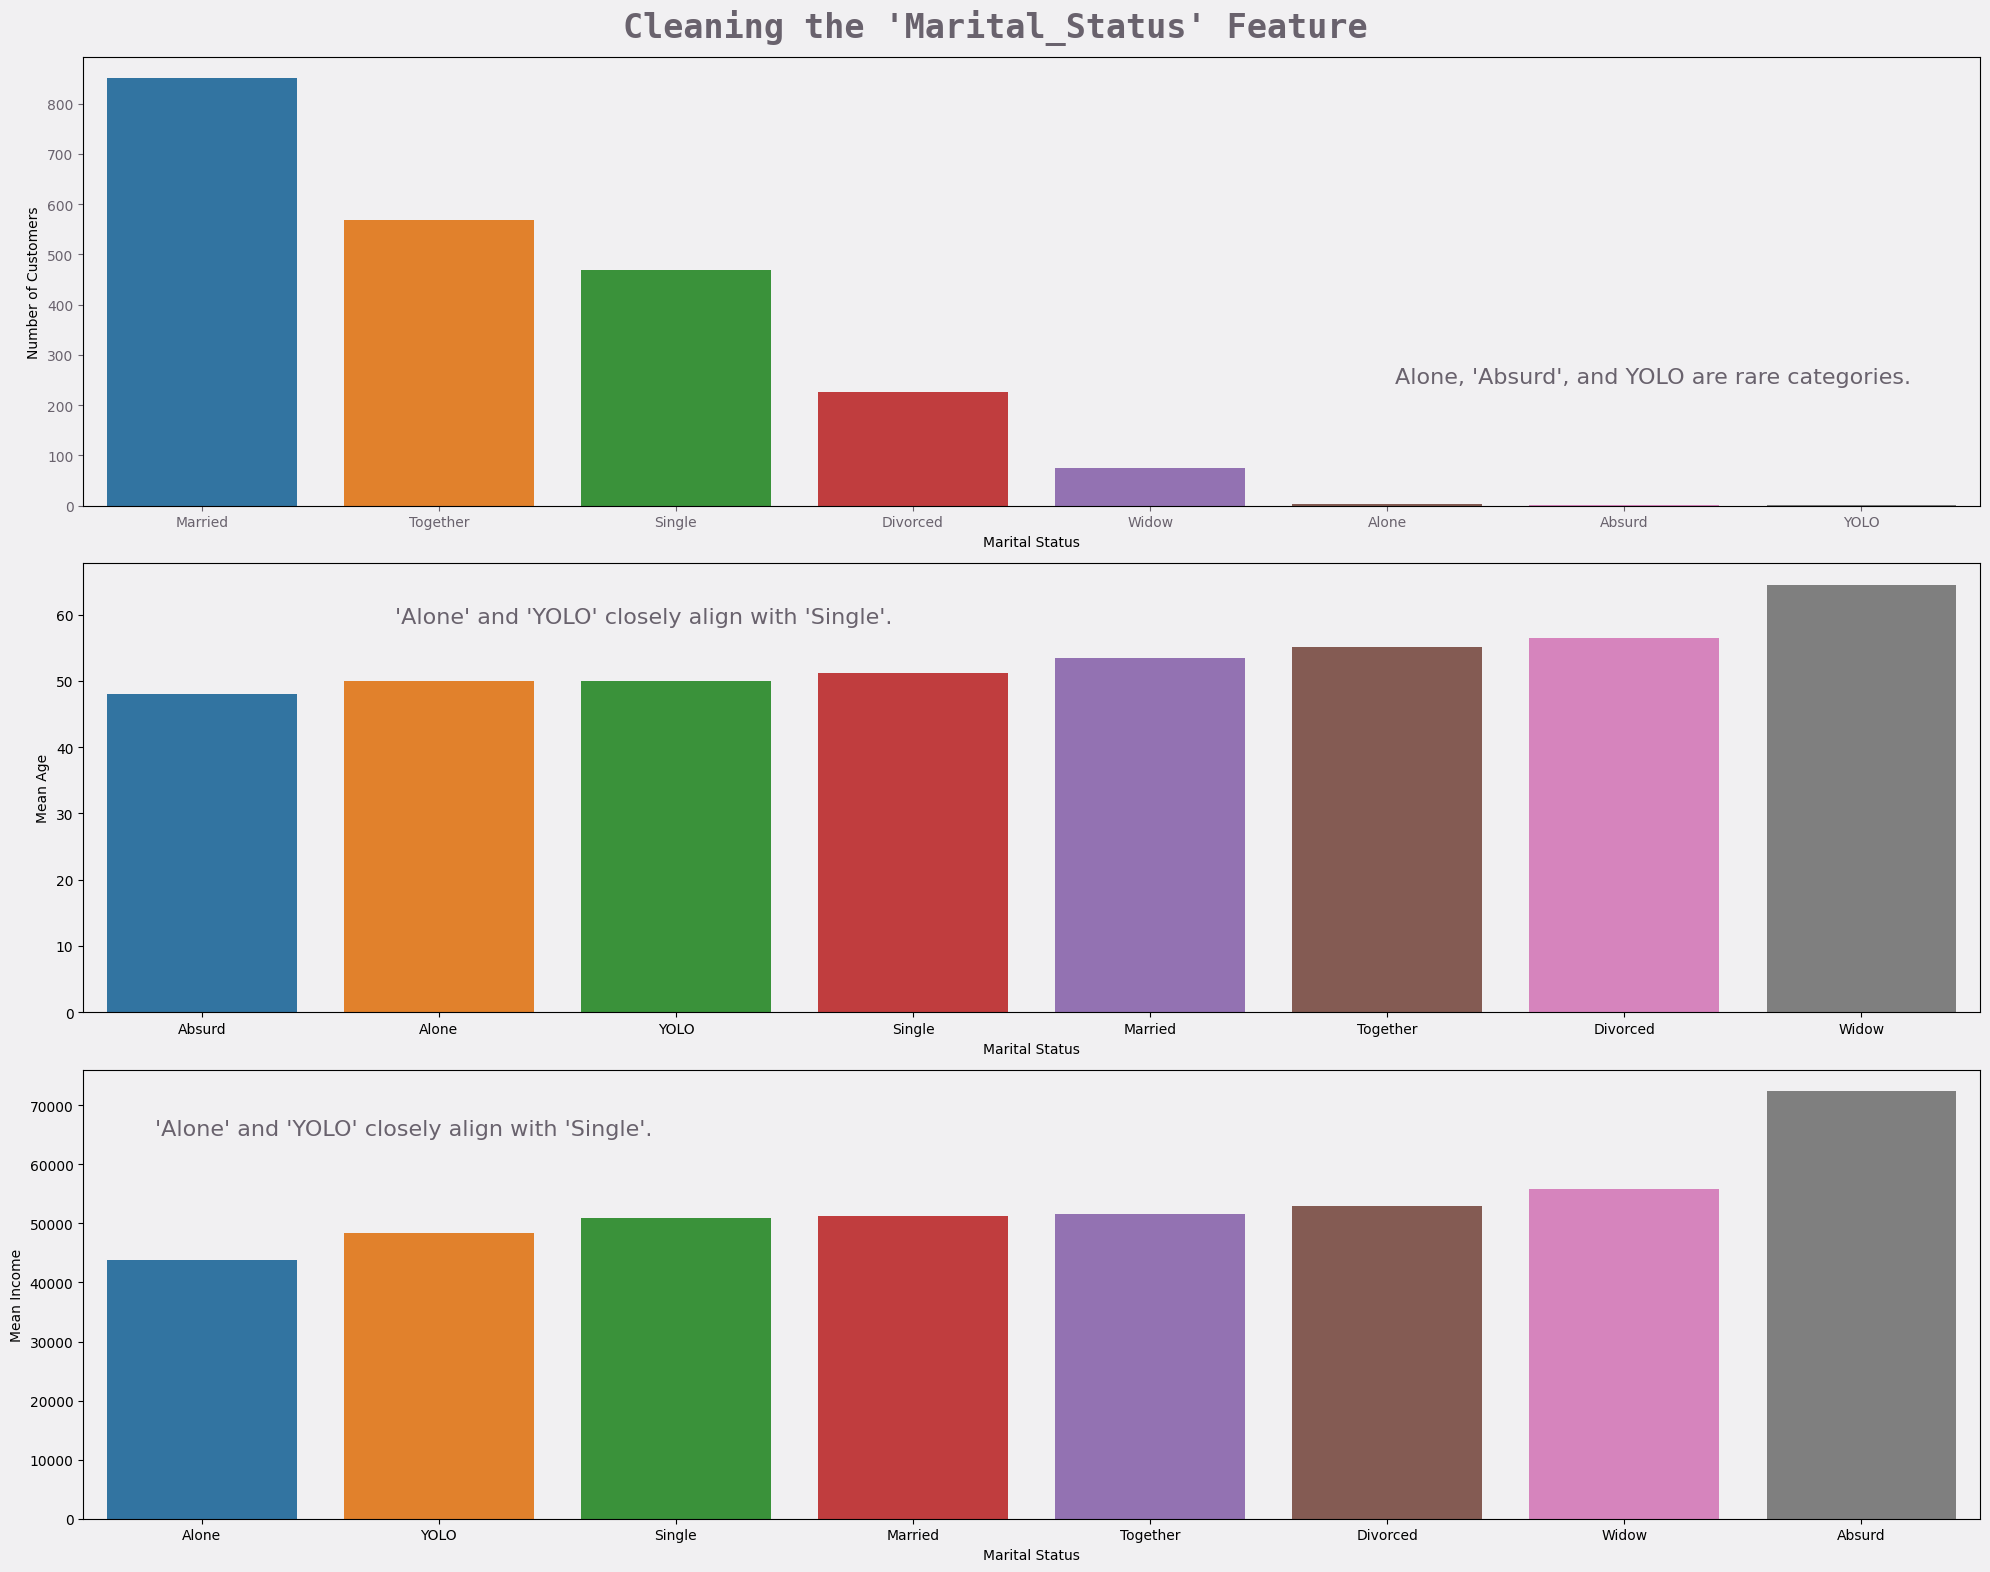

In [ ]:
# Plot Marital Features Distribution
# Calculate the order for the Age plot
order_age = df.groupby('Marital_Status')['Age'].mean().sort_values().index

# Calculate the order for the Income plot
order_income = df.groupby('Marital_Status')['Income'].mean().sort_values().index

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 16), facecolor='#F1F0F2')

sns.countplot(x='Marital_Status', data=df, ax=ax1, order=df['Marital_Status'].value_counts().index)
ax1.set_facecolor('#F1F0F2')
ax1.set_xlabel('Marital Status')
ax1.set_ylabel('Number of Customers')
ax1.tick_params(axis='both', colors='#69626D')

# Plot for Age
sns.barplot(x='Marital_Status', y='Age', data=df, estimator=np.mean, ci=None, ax=ax2, order=order_age)
ax2.set_facecolor('#F1F0F2')
ax2.set_ylabel('Mean Age')
ax2.set_xlabel('Marital Status')

# Plot for Income
sns.barplot(x='Marital_Status', y='Income', data=df, estimator=np.mean, ci=None, ax=ax3, order=order_income)
ax3.set_facecolor('#F1F0F2')
ax3.set_ylabel('Mean Income')
ax3.set_xlabel('Marital Status')

# Main title and subtitle
fig.suptitle("Cleaning the 'Marital_Status' Feature", fontsize=24, fontweight='semibold', fontfamily='monospace', color="#69626D")
plt.figtext(0.7, 0.75, "Alone, 'Absurd', and YOLO are rare categories.", ha="left", va="center", fontsize=16, fontfamily='sans-serif', color="#69626D")
plt.figtext(0.2, 0.6, "'Alone' and 'YOLO' closely align with 'Single'.", ha="left", va="center", fontsize=16, fontfamily='sans-serif', color="#69626D")
plt.figtext(0.08, 0.28, "'Alone' and 'YOLO' closely align with 'Single'.", ha="left", va="center", fontsize=16, fontfamily='sans-serif', color="#69626D")

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust the space to fit the main title and subtitle
plt.show()


In [ ]:
# Merge 'Alone' and 'YOLO' into 'Single'
categories_to_merge = ["Alone", "YOLO"]
df['Marital_Status'] = df['Marital_Status'].replace(categories_to_merge, "Single")

# Remove rows where Marital_Status is 'Absurd'
df = df[df['Marital_Status'] != 'Absurd']

## Exploring Education

In [ ]:
def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(df, *['Education'], **{})
chart

- While "Graduation" is the most frequent education category, it's important to note that the specific definition of "Graduation" isn't provided, and it could encompass various types of undergraduate degrees or certifications.
- "PhD" and "Master" are the next two most prevalent education categories, indicating individuals with advanced degrees.
- "2n Cycle" and "Basic" have the lowest counts

# saving cleaned data

In [ ]:
df.to_csv('df_clean.csv', index=False)